In [10]:
import nmm
import jax.numpy as jnp
from nmm.utils import Qobj

In [11]:
bath=nmm.OverdampedBath(coupling=0.05,cutoff=5,T=1)

In [12]:
w,w1=1,2
t=jnp.linspace(0,10,100)

In [13]:
sp=Qobj(jnp.array([[0,0],[1,0]]))
sm=Qobj(jnp.array([[0,1],[0,0]]))
sz=Qobj(jnp.array([[1,0],[0,-1]]))
sx=sm+sp
rho0=Qobj(jnp.array([[1,1],[1,1]]))*0.5

In [14]:
cc=nmm.cumulant.csolve(Hsys=sz*0.5,baths=[bath],t=t,Qs=[sx],eps=1e-6,cython=True)

In [15]:
rho=cc.evolution(rho0,False)

Computing Exponential of Generators . . . .: 100%|██████████| 100/100 [00:00<00:00, 9978.36it/s]


In [12]:
import matplotlib.pyplot as plt

In [13]:
def population(s,i,j):
    return [l.data[i,j].item() for l in s]

/home/mcditoos/anaconda3/envs/cumulant/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mcditoos/anaconda3/envs/cumulant/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


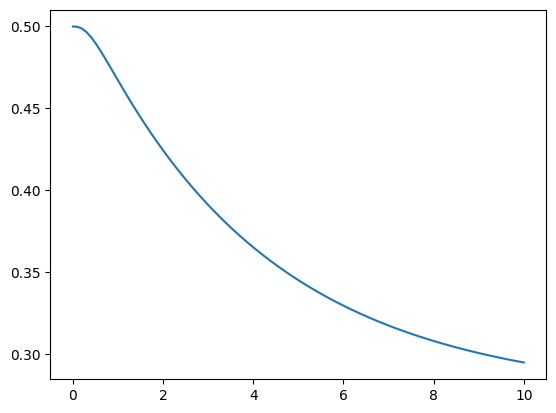

In [14]:
plt.plot(t,population(rho,0,0))
plt.show()

In [31]:
import sys
import numpy as np
from numba import jit





class SemiInfiniteFunc:
    """
    Argument transform from (start, +-oo) to (0, 1)
    """
    def __init__(self, func, start, infty):
        self._func = func
        self._start = start
        self._sgn = -1 if infty < 0 else 1
        # Overflow threshold for the 1/t**2 factor
        self._tmin = sys.float_info.min**0.5

    def get_t(self, x):
        z = self._sgn * (x - self._start) + 1
        if z == 0:
            # Can happen only if point not in range
            return np.inf
        return 1 / z

    def __call__(self, t):
        if t < self._tmin:
            return 0.0
        else:
            x = self._start + self._sgn * (1 - t) / t
            f = self._func(x)
            return self._sgn * (f / t) / t




def _quadrature_gk(a, b, f, norm_func, x, w, v):
    """
    Generic Gauss-Kronrod quadrature
    """

    fv = [0.0]*len(x)

    c = 0.5 * (a + b)
    h = 0.5 * (b - a)

    # Gauss-Kronrod
    s_k = 0.0
    s_k_abs = 0.0
    for i in range(len(x)):
        ff = f(c + h*x[i])
        fv[i] = ff

        vv = v[i]

        # \int f(x)
        s_k += vv * ff
        # \int |f(x)|
        s_k_abs += vv * abs(ff)

    # Gauss
    s_g = 0.0
    for i in range(len(w)):
        s_g += w[i] * fv[2*i + 1]

    # Quadrature of abs-deviation from average
    s_k_dabs = 0.0
    y0 = s_k / 2.0
    for i in range(len(x)):
        # \int |f(x) - y0|
        s_k_dabs += v[i] * abs(fv[i] - y0)

    # Use similar error estimation as quadpack
    err = float(norm_func((s_k - s_g) * h))
    dabs = float(norm_func(s_k_dabs * h))
    if dabs != 0 and err != 0:
        err = dabs * min(1.0, (200 * err / dabs)**1.5)

    eps = sys.float_info.epsilon
    round_err = float(norm_func(50 * eps * h * s_k_abs))

    if round_err > sys.float_info.min:
        err = max(err, round_err)

    return h * s_k, err, round_err


def _quadrature_gk15(a, b, f, norm_func):
    """
    Gauss-Kronrod 15 quadrature with error estimate
    """
    # Gauss-Kronrod points
    x = (0.991455371120812639206854697526329,
         0.949107912342758524526189684047851,
         0.864864423359769072789712788640926,
         0.741531185599394439863864773280788,
         0.586087235467691130294144838258730,
         0.405845151377397166906606412076961,
         0.207784955007898467600689403773245,
         0.000000000000000000000000000000000,
         -0.207784955007898467600689403773245,
         -0.405845151377397166906606412076961,
         -0.586087235467691130294144838258730,
         -0.741531185599394439863864773280788,
         -0.864864423359769072789712788640926,
         -0.949107912342758524526189684047851,
         -0.991455371120812639206854697526329)

    # 7-point weights
    w = (0.129484966168869693270611432679082,
         0.279705391489276667901467771423780,
         0.381830050505118944950369775488975,
         0.417959183673469387755102040816327,
         0.381830050505118944950369775488975,
         0.279705391489276667901467771423780,
         0.129484966168869693270611432679082)

    # 15-point weights
    v = (0.022935322010529224963732008058970,
         0.063092092629978553290700663189204,
         0.104790010322250183839876322541518,
         0.140653259715525918745189590510238,
         0.169004726639267902826583426598550,
         0.190350578064785409913256402421014,
         0.204432940075298892414161999234649,
         0.209482141084727828012999174891714,
         0.204432940075298892414161999234649,
         0.190350578064785409913256402421014,
         0.169004726639267902826583426598550,
         0.140653259715525918745189590510238,
         0.104790010322250183839876322541518,
         0.063092092629978553290700663189204,
         0.022935322010529224963732008058970)

    return _quadrature_gk(a, b, f, norm_func, x, w, v)


def _quadrature_gk21(a, b, f, norm_func):
    """
    Gauss-Kronrod 21 quadrature with error estimate
    """
    # Gauss-Kronrod points
    x = (0.995657163025808080735527280689003,
         0.973906528517171720077964012084452,
         0.930157491355708226001207180059508,
         0.865063366688984510732096688423493,
         0.780817726586416897063717578345042,
         0.679409568299024406234327365114874,
         0.562757134668604683339000099272694,
         0.433395394129247190799265943165784,
         0.294392862701460198131126603103866,
         0.148874338981631210884826001129720,
         0,
         -0.148874338981631210884826001129720,
         -0.294392862701460198131126603103866,
         -0.433395394129247190799265943165784,
         -0.562757134668604683339000099272694,
         -0.679409568299024406234327365114874,
         -0.780817726586416897063717578345042,
         -0.865063366688984510732096688423493,
         -0.930157491355708226001207180059508,
         -0.973906528517171720077964012084452,
         -0.995657163025808080735527280689003)

    # 10-point weights
    w = (0.066671344308688137593568809893332,
         0.149451349150580593145776339657697,
         0.219086362515982043995534934228163,
         0.269266719309996355091226921569469,
         0.295524224714752870173892994651338,
         0.295524224714752870173892994651338,
         0.269266719309996355091226921569469,
         0.219086362515982043995534934228163,
         0.149451349150580593145776339657697,
         0.066671344308688137593568809893332)

    # 21-point weights
    v = (0.011694638867371874278064396062192,
         0.032558162307964727478818972459390,
         0.054755896574351996031381300244580,
         0.075039674810919952767043140916190,
         0.093125454583697605535065465083366,
         0.109387158802297641899210590325805,
         0.123491976262065851077958109831074,
         0.134709217311473325928054001771707,
         0.142775938577060080797094273138717,
         0.147739104901338491374841515972068,
         0.149445554002916905664936468389821,
         0.147739104901338491374841515972068,
         0.142775938577060080797094273138717,
         0.134709217311473325928054001771707,
         0.123491976262065851077958109831074,
         0.109387158802297641899210590325805,
         0.093125454583697605535065465083366,
         0.075039674810919952767043140916190,
         0.054755896574351996031381300244580,
         0.032558162307964727478818972459390,
         0.011694638867371874278064396062192)

    return _quadrature_gk(a, b, f, norm_func, x, w, v)


def _gauss_kron(f,a,b,tol=1e-6):
    integral,err,rnd=_quadrature_gk15(a,b,f,np.linalg.norm)  
    if abs(err)<tol:
        q= integral
    else:
        c=(a+b)/2
        qa= _gauss_kron(f,a,c,tol)
        qb=_gauss_kron(f,c,b,tol)   
        q=qa+qb 
    return q

def gauss_kron(f,a,b,tol=1e-6,args=()):
    func= lambda x: f(x,*args)
    if (a==0) and (b ==np.infty):
        func2=SemiInfiniteFunc(func,0,np.infty)
        b=1
    return _gauss_kron(func2,a,b,tol)

def quad_gauss(f,a,b,tol=1e-6,args=()):
    if isinstance(args[-1],np.ndarray):
        params=args[:-1]
        return [gauss_kron(f,a,b,tol,args=(*params,i)) for i in args[-1]]
    else:
        return gauss_kron(f,a,b,tol,args=args)

import functools

In [54]:
from numbers import Number

In [55]:
A=spost(sm)

In [56]:
A*A

SuperOperator: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]